In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import io
import base64
import tempfile
from IPython.display import HTML
from numpy import loadtxt
from mpc import util

from controller_utils import CartpoleDx, sample_initial_signal, WeightClipper, episode_loss
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
import mpc.util as eutil
from controllers import DDeePC

%matplotlib inline

/opt/conda/envs/deepc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
Tini = 4
m = 1
p = 4
Tf = 20
T = (m+1)*(Tini + Tf + p) + 14
n_batch = 100
device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = 'cpu'
print(device)
ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise =  np.random.randn(*yd.shape)*0.001
yd = yd + noise
dx_deepc = CartpoleDx().to(device)
dx_mpc = CartpoleDx().to(device)
clipper = WeightClipper()
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

cuda


In [5]:
np.logspace(start=-4, stop=4, base=10, num=20)
a = torch.randn((4,20))
b = torch.randn((4,20))
loss = torch.nn.MSELoss()
print(loss(input=(b), target=(torch.zeros(a.shape))))

tensor(1.1462)


In [44]:
u_constraints = np.ones(Tf)*3
y_constraints = np.kron(np.ones(Tf), np.array([0.25, 0.2, 0.15, 0.2]))
r = torch.ones(m)*0.01
q = torch.ones(p)*100 
lambdag = np.logspace(start=-4, stop=4, base=10, num=20)
lam_y = torch.Tensor([370.258]).to(device)

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic=True, q=q, r=r, lam_y=lam_y
).to(device)

mpc_T = Tf
q, p_ = dx_mpc.get_true_obj()
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
    mpc_T, n_batch, 1, 1
).to(device)
p_ = p_.unsqueeze(0).repeat(mpc_T, n_batch, 1).to(device)

mpc_controller = mpc.MPC(
        dx_mpc.n_state, dx_mpc.n_ctrl, Tf,
        u_init=None,
        u_lower=dx_mpc.lower, u_upper=dx_mpc.upper,
        lqr_iter=50,
        verbose=0,
        exit_unconverged=False,
        detach_unconverged=False,
        backprop=False,
        linesearch_decay=dx_mpc.linesearch_decay,
        max_linesearch_iter=dx_mpc.max_linesearch_iter,
        grad_method=GradMethods.AUTO_DIFF,
        eps=1e-2,
).to(device)

F, f = mpc_controller.linearize_dynamics(torch.zeros((mpc_T,n_batch,4)), util.detach_maybe(torch.zeros((mpc_T,n_batch,1))), dx_mpc, diff=True)
F, f = F.to(device), f.to(device)

In [45]:
lamy = [370]
lamg2 = np.arange(0.001, 400, 8)
episodes = 60
ref = torch.zeros(size=(n_batch,p))
perfect = torch.kron(torch.ones(episodes+Tini), ref).to(device)
ref = torch.kron(torch.ones(Tf), ref).to(device)
n_row = np.sqrt(n_batch).astype(np.uint8)
n_col = n_row
performance = np.zeros((20,20)) # (0,0) - l1=10e-4, l2=10e-4

for i, ly in enumerate(lamy):

    controller.lam_y = torch.Tensor([ly]).to(device)

    for j, l2 in enumerate(tqdm(lambdag)):
        controller.lam_g2 = torch.Tensor([l2]).to(device)
        uini = torch.zeros(size=(n_batch, Tini*m)).to(device)
        zero = torch.zeros(n_batch)
        th = uniform((n_batch), -0.01, 0.01)
        x =  torch.stack((zero, zero, th, zero), dim=1).to(device)
        yini = x.repeat(1,Tini).to(device)
        deepc_traj = yini
        # mpc_traj = x

        for k, l1 in enumerate(lambdag):
            controller.lam_g1 = torch.Tensor([l1]).to(device)
            noise = torch.randn(yini.shape).to(device)*0.001       
            _, u_pred, _, _ = controller(ref=ref, y_ini=yini+noise, u_ini=uini)
            input = u_pred[:,:m]
            y = dx_deepc(deepc_traj[:,-p:], input)
            yini = torch.cat((yini[:, p:], y), axis=1)
            uini = torch.cat((uini[:, m:], input), axis=1)
            deepc_traj = torch.cat((deepc_traj, y), axis=1)

            # _, nominal_actions, _ = mpc_controller(x, QuadCost(Q, p_), LinDx(F,f))
            # action = nominal_actions[:,:m]
            # x = dx_mpc(mpc_traj[:,-p:], nominal_actions[0])
            # mpc_traj = torch.cat((mpc_traj, x), axis=1)   
            diff = torch.abs(deepc_traj[:,p*Tini:])
            sum = torch.sum(diff, axis=1)
            performance[j,k] = sum.detach().cpu().numpy()

(1, 50, 50)


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/envs/deepc/lib/python3.9/site-packages/diffcp/cone_program.py:295: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
  2%|▏         | 1/50 [08:01<6:33:21, 481.66s/it]

Failure:interrupted
Failure:interrupted
Failure:interrupted
Failure:interrupted
Failure:interrupted
Failure:interrupted
Failure:interrupted
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


SolverError: Solver scs returned status interrupted

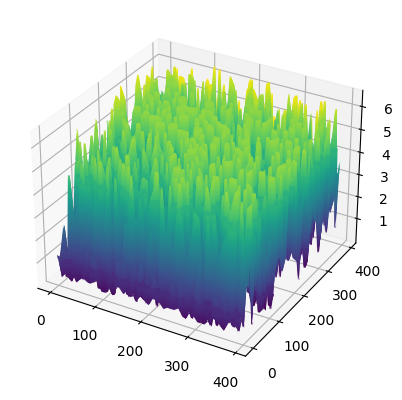

In [ ]:
from mpl_toolkits import mplot3d

performance[0]
X, Y = np.meshgrid(lamg2, lamg2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, performance[0], 250)